In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import or_

from app.models import Session, Headline, Article, Agency
from app.utils import Country, Config

In [2]:
s = Session()
data = s.query(
    Headline.id, Article.id, Agency.name, Headline.processed, Headline.first_accessed, Headline.last_accessed
).join(Headline.article).join(Article.agency).filter(
    or_(Agency._country == Country.us.value, Agency.name.in_(Config.exempted_foreign_media))
).all()
s.close()

In [3]:
raw_df = pd.DataFrame(data, columns=['hid', 'aid', 'agency', 'title', 'first', 'last'])
print(raw_df.shape)

(720502, 6)


In [4]:
from tqdm import tqdm

tqdm.pandas()
# Take only the first 1000 rows for now
# df = raw_df.head(10000).copy()
df = raw_df.copy()
# Convert the datetimes from utc to NY time. They're not timezone aware
df['first'] = df['first'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
df['last'] = df['last'].dt.tz_localize('utc').dt.tz_convert('America/New_York')
# Get the timedelta between the first and last access
df['delta'] = df['last'] - df['first']
# Drop the rows where the delta is more than 3 days. This should filter out normal links not to real stories
df = df[df['delta'] <= pd.Timedelta(days=3)]

In [5]:
# filtering by us and exempted media really improves this!
def get_hours(row):
    first = row['first']
    last = row['last']
    # Zero out the minutes and seconds
    first_ts = first.replace(minute=0, second=0, microsecond=0).timestamp()
    last_ts = last.replace(minute=0, second=0, microsecond=0).timestamp()
    # get every half hour between the first and last access
    hours = np.arange(first_ts, last_ts, 1800, dtype=int)
    # Filter out the hours that are not in the same day as the first access
    return hours[(hours <= last_ts) & (hours >= first_ts)]
    
df['halfhour'] = df.progress_apply(get_hours, axis=1)

100%|██████████| 682300/682300 [00:20<00:00, 32819.55it/s]


In [6]:
# Next we explode the hours column so that each row corresponds to a single hour
df = df.explode('halfhour')
# Reset the index
df.reset_index(drop=True, inplace=True)
# Convert the hours column to a datetime
df['halfhour'] = pd.to_datetime(df['halfhour'], unit='s')
df = df[['title', 'halfhour']]

In [7]:
df.sample(5)

,title,halfhour
12784645,'Jeopardy!' spinoff focusing on pop culture tr...,2024-05-15 02:30:00
52904,"Queen Camilla, once shunned by British public,...",2024-02-17 05:30:00
14249930,Aaron Rodgers is back with Jets and still the ...,2024-05-22 02:30:00
3280543,Biden slams Trump for saying there's 'a lot yo...,2024-03-12 11:00:00
5247098,China Uses Surprise Data Announcements to Coun...,2024-03-25 06:00:00


In [8]:
# Group by the hours column and apply the get_newsiness function to the titles
# Eventually we can speed this up with multiprocessing I think.
# For now though, this is fine. More than a million headlines Seems to be taking under 20 minutes.
# Recalculation will be expensive! But we won't do it often.
# We'll save the results as a csv for incorporation in the website.
# Simple solutions are best.

import multiprocessing as mp
from app.analysis.newsiness import get_newsiness

titles_by_hour = [group["title"].tolist() for _, group in df.groupby('halfhour')]
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.imap(get_newsiness, titles_by_hour)
    newsiness = list(tqdm(results, total=len(titles_by_hour)))


# It took almost 22 minutes for the first run.
# newsiness = df.groupby('hours')['title'].progress_apply(get_newsiness)


100%|██████████| 4838/4838 [00:53<00:00, 90.15it/s] 


In [9]:
# Create a dataframe from the groupby object and add a column of the newsiness
newsiness_df = df.groupby('halfhour').first().reset_index()
newsiness_df = newsiness_df[['halfhour']]
newsiness_df['newsiness'] = newsiness
newsiness_df.head()

,halfhour,newsiness
0,2024-02-16 20:00:00,2.750258
1,2024-02-16 20:30:00,2.750258
2,2024-02-16 21:00:00,2.501889
3,2024-02-16 21:30:00,2.501889
4,2024-02-16 22:00:00,2.610354


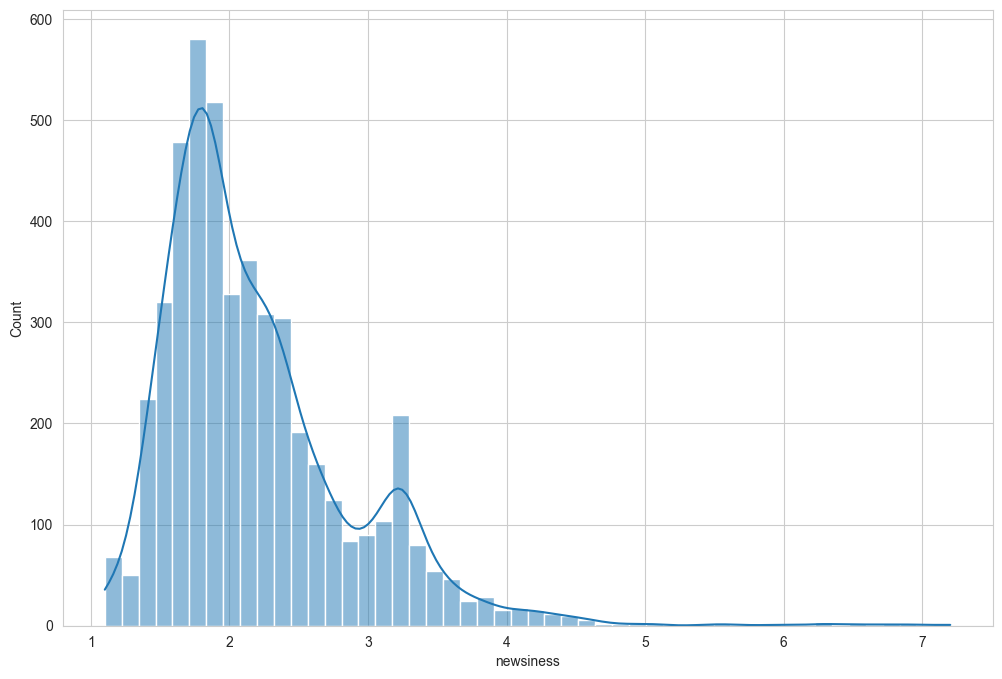

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot a histogram of the newsiness
plt.figure(figsize=(12, 8))
sns.histplot(newsiness_df['newsiness'], bins=50, kde=True)
plt.show()


In [11]:
# Get some statistics
newsiness_df['newsiness'].describe()

count    4838.000000
mean        2.200360
std         0.691717
min         1.100894
25%         1.732549
50%         2.010163
75%         2.492280
max         7.202365
Name: newsiness, dtype: float64

In [12]:
# Let's sample some headlines from the highest newsiness hour
df[df['halfhour'] == newsiness_df[newsiness_df['newsiness'] == newsiness_df['newsiness'].max()]['halfhour'].values[0]].sample(10)

,title,halfhour
13581621,Youngkin vetoes Virginia contraception accessi...,2024-05-20 15:00:00
13894234,Operation Oust Joe Biden is Very Real- Democra...,2024-05-20 15:00:00
13690629,"Feeling good about feeling bad, or how guilt c...",2024-05-20 15:00:00
13718487,Airbnb carbon monoxide detector mandate would ...,2024-05-20 15:00:00
13885967,"Michael Cohen resumes testimony, with closing ...",2024-05-20 15:00:00
13660424,Bill Maher Nails What's at the Heart of the Le...,2024-05-20 15:00:00
13735759,"Despite apology, Sean 'Diddy' Combs faces peri...",2024-05-20 15:00:00
13882943,MLB power rankings: AL team's rise from the as...,2024-05-20 15:00:00
13794882,TikTok influencers sue U.S. government Eight T...,2024-05-20 15:00:00
13745881,Illinois Bill Would Punish Teachers for Sexual...,2024-05-20 15:00:00


In [13]:
# Now create a column of the day of the week
newsiness_df['day'] = newsiness_df['halfhour'].dt.day_name()
# Convert the "hours" column, which is actually halfhour to the hour of the day to an integer representing the 24 hour clock (00, 30, 60, 90, etc)
newsiness_df['halfhour'] = newsiness_df['halfhour'].dt.hour * 60 + newsiness_df['halfhour'].dt.minute

# Create a df of group by hour and day and take the mean of the newsiness and the median of the newsiness
newsiness_df = newsiness_df.groupby(['halfhour', 'day'])['newsiness'].agg(['mean', 'median', 'std']).reset_index()
newsiness_df.head()

,halfhour,day,mean,median,std
0,0,Friday,1.942678,1.883297,0.522981
1,0,Monday,2.410457,2.325975,0.622616
2,0,Saturday,2.407826,2.154275,0.735628
3,0,Sunday,2.225565,2.126182,0.611258
4,0,Thursday,2.200948,2.055531,0.591653


In [14]:
newsiness_df.to_csv('../newsiness.csv', index=False)

PermissionError: [Errno 13] Permission denied: '../newsiness.csv'

In [ ]:
# Plot the mean newsiness by hour
import seaborn as sns
import matplotlib.pyplot as plt

# Colorblind friendly
sns.set_palette('colorblind')
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='mean', hue='day', lw=3)
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['mean'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()

In [ ]:
# Plot the median newsiness by hour
plt.figure(figsize=(12, 8))
sns.lineplot(data=newsiness_df, x='halfhour', y='median', hue='day', lw=3)
# Add a title
plt.title('Median Newsiness by Hour')
# Add annotations for the days
for i, day in enumerate(newsiness_df['day'].unique()):
    plt.text(23, newsiness_df[newsiness_df['day'] == day]['median'].values[-1], day, fontsize=12,
             color=sns.color_palette('colorblind')[i])
plt.show()


In [ ]:
# Rank the days by newsiness
newsiness_df.groupby('day')['mean'].mean().sort_values(ascending=False)

In [ ]:
# Rank the hours by newsiness
newsiness_df.groupby('halfhour')['mean'].mean().sort_values(ascending=False)

In [ ]:
# Find the newsiest hourday
newsiness_df[newsiness_df['mean'] == newsiness_df['mean'].max()]

In [ ]:
# Group by morning, afternoon, evening, night and find the busiest period on which day
newsiness_df['period'] = pd.cut(newsiness_df['halfhour'], bins=[v * 60 for v in [0, 6, 12, 18, 24]],
                                labels=['night', 'morning', 'afternoon', 'evening'])
newsiness_df.groupby(['day', 'period'])['mean'].mean().sort_values(ascending=False)
